In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import random 
import os

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist
from work.thermo import haversine 

settings_path = 'settings/sam3d.yaml'
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

test = xr.open_dataset("/bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440_PP.nc")
z_targets = [300, 2000, 4000, 8000, 12000]
z_indices = [np.abs(test.z.values - target).argmin() for target in z_targets]
z_all = test.z.values.copy()
z_tropo = z_all[:np.abs(test.z.values - 15000).argmin()+1] # L'alitude de la Troposphère est à 15000m à l'équateur max non ? utiliser les pressions ? 
print("z_shear index", z_indices)
print("len z_tropo", len(z_tropo))

p_targets = [975, 800, 600, 350, 200] #mbar or hPa
p_indices = [np.abs(test.p.values-target).argmin() for target in p_targets] ## Est ce que je dois être plus flexible sur l'extraction des coordonnées de pression ? 
                                                                            ## Je peux le faire en extrayant les vents puis interpolant sur ma grille régulière ! 
p_all = test.p.values.copy()
p_tropo = p_all[:np.abs(test.z.values - 15000).argmin()+1]
print("p       index", p_indices)
test.close()

In [2]:
import os 

duration_min = 6
surfmaxkm2_min = 25000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
filename_save = f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
save_storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)

# os.remove(save_storms_path)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

## FileTracking is ft
ft = storms[[ 
    "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K", ## General characteristics
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity" ## General characteristics
             ]]

to_drop = []
for iDCS in ft.DCS_number.values : 
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = st.get_frame_data(ft, iDCS)
    # extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d)
    times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
    t = len(times_3d_conv)
    if t<3 or i_smax < 0:
        to_drop.append(iDCS)
ft = ft.drop_sel(DCS_number = to_drop)

## Valid times for 3d var are %6==0 
t=0
ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0])


In [3]:
ft

<xarray.Dataset>
Dimensions:              (DCS_number: 225, time: 911)
Coordinates:
  * DCS_number           (DCS_number) int64 153463 153510 ... 287935 291447
  * time                 (time) int64 817681 817682 817683 ... 818590 818591
Data variables: (12/14)
    INT_UTC_timeInit     (DCS_number) float64 ...
    INT_UTC_timeEnd      (DCS_number) float64 ...
    INT_duration         (DCS_number) float64 ...
    INT_surfcumkm2_241K  (DCS_number) float64 ...
    INT_velocityAvg      (DCS_number) float64 ...
    INT_surfmaxkm2_241K  (DCS_number) float64 ...
    ...                   ...
    LC_UTC_time          (DCS_number, time) float64 ...
    LC_ecc_241K          (DCS_number, time) float64 ...
    LC_orientation_241K  (DCS_number, time) float64 ...
    LC_surfkm2_241K      (DCS_number, time) float64 ...
    LC_tb_90th           (DCS_number, time) float64 ...
    LC_velocity          (DCS_number, time) float64 ...

## Wind env dev

In [4]:
## Valid times for 3d var are %6==0 
t=0
ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0])

while t<4: 
    iDCS = random.choice(ft_3d.DCS_number.values)

    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = 1.5)

    times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
    t = len(times_3d_conv)

/tmp/ipykernel_2389841/2004043180.py:84: RuntimeWarning: invalid value encountered in divide
  composite_tangeant = tangeant_wind_env_by_age / count_by_age
/tmp/ipykernel_2389841/2004043180.py:85: RuntimeWarning: invalid value encountered in divide
  composite_normal = normal_wind_env_by_age / count_by_age


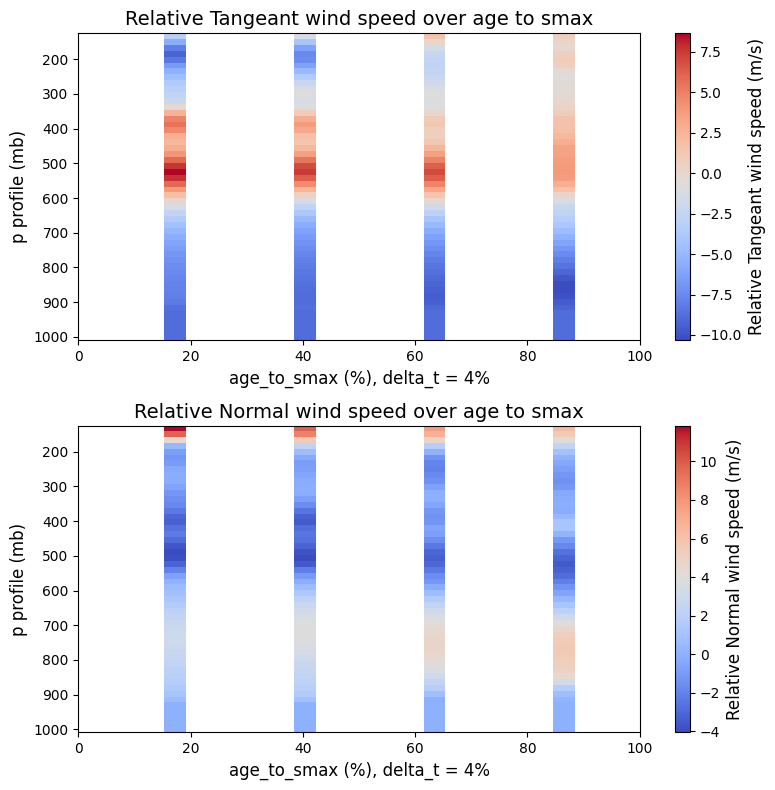

In [5]:
def plot_wind_env_by_age(tangeant, normal, width = 8, height = 8):
    # Define your desired aspect ratio by controlling the figure size
    fig, axs = plt.subplots(2, 1, figsize=(width, height))  # Replace width and height with desired values
    for ax, arr, var in zip(axs, [tangeant, normal], ["Relative Tangeant", "Relative Normal"]):
        x_vals = np.linspace(0, 100, normal.shape[1])  # Adjust according to your data
        y_vals = np.array(p_tropo)  # Ensure z_all is a NumPy array of actual z-axis values (in meters)
            # Adjust according to your data

        cax = ax.imshow(arr, origin="lower", aspect='auto',
                        cmap='coolwarm',  # Replace 'coolwarm' with your preferred colormap
                        extent=[x_vals.min(), x_vals.max(), y_vals.max(), y_vals.min()])  # Custom x/y axis values

        # Add colorbar with label
        cbar = fig.colorbar(cax)
        cbar.set_label(f'{var} wind speed (m/s)', fontsize=12)  # Replace with the appropriate label

        # Add labels and title
        ax.set_title(f'{var} wind speed over age to smax', fontsize=14)  
        ax.set_xlabel('age_to_smax (%), delta_t = 4%', fontsize=12)  
        ax.set_ylabel('p profile (mb)', fontsize=12)  
        # Customize axis limits if necessary
        ax.set_xlim([x_vals.min(), x_vals.max()])  # Adjust the x-axis limits as needed
        ax.set_ylim([y_vals.max(), y_vals.min()])  # Adjust the y-axis limits as needed
    return fig

# plot_wind_env_by_age(tangeant_wind_env_by_age, normal_wind_env_by_age)


def get_wind_env_by_age(i):
    slice_lat, slice_lon, extent = slices_lat[i], slices_lon[i], extents[i] ## slices are correctly 3d ones

    le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
    le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}

    u = hdlr.load_var(cs, "U", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).U[0]
    v = hdlr.load_var(cs, "V", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).V[0]
    # w = hdlr.load_var(cs, "W", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).W[0]
    seg = hdlr.load_seg(times_3d[i], sel_dict = le_dico_long)[0].values #.sel(le_dico_long)

    ##### DCS MATURATION TOTAL PROPAGATION #####
    lon_smax, lat_smax = lons[i_smax], lats[i_smax]
    lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
    lons[0], lats[0], lon_propa, lat_propa #angles='xy', scale_units='xy'
    
    distance_propagation = haversine(lons[0], lats[0], lon_smax, lat_smax)
    avg_system_speed = distance_propagation/(i_smax*30*60)
    norm_propa = np.sqrt(lon_propa**2 + lat_propa**2) 

    u_propa, v_propa = lon_propa/norm_propa, lat_propa/norm_propa
    mask = (seg != iDCS)
    u_env_masked, v_env_masked = np.where(mask, u, np.nan), np.where(mask, v, np.nan)

    avg_u_propa, avg_v_propa = avg_system_speed*u_propa, avg_system_speed*v_propa

    tangeant_propa_speed = avg_u_propa*u_propa + avg_v_propa*v_propa
    normal_propa_speed = -avg_u_propa*v_propa + avg_v_propa*u_propa
    
    tangeant_wind_env = u_env_masked * u_propa + v_env_masked * v_propa
    normal_wind_env = -u_env_masked * v_propa + v_env_masked * u_propa

    return tangeant_wind_env-tangeant_propa_speed, normal_wind_env-normal_propa_speed
    

# Compute data
tangeant_wind_env_by_age = np.full(fill_value = float(0), shape=(len(z_tropo), 26))
normal_wind_env_by_age = np.full(fill_value = float(0), shape=(len(z_tropo), 26))
count_by_age = np.full(fill_value = float(0), shape=(1, 26))

for i in range(t):
    tangeant_wind_env, normal_wind_env = get_wind_env_by_age(i)
    z_tangeant_wind_env_mean = np.nanmean(tangeant_wind_env, axis = (1,2))
    # print(z_tangeant_wind_env_mean.shape)
    z_normal_wind_env_mean   = np.nanmean(  normal_wind_env, axis = (1,2))

    age_to_smax = int(100*np.round((times_3d[i] - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))

    i_age = age_to_smax//4 # because 100/25 is 4  

    tangeant_wind_env_by_age[:,i_age] += z_tangeant_wind_env_mean
    normal_wind_env_by_age[:, i_age] += z_normal_wind_env_mean
    count_by_age[0,i_age]+=1

# After accumulation, divide by count_by_age
composite_tangeant = tangeant_wind_env_by_age / count_by_age
composite_normal = normal_wind_env_by_age / count_by_age

# Replace areas where count_by_age == 0 with NaN
composite_tangeant = np.where(count_by_age == 0, np.nan, composite_tangeant)
composite_normal = np.where(count_by_age == 0, np.nan, composite_normal)

fig = plot_wind_env_by_age(composite_tangeant, composite_normal)

plt.tight_layout()
filename = "sahelian_composite_wind_env_by_age_v0.png"
plt.savefig(f"/home/mcarenso/code/shear/output/{filename}")

# Systems classification
### All systems 

In [8]:
duration_min = 12
surfmaxkm2_min = 50000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
filename_save = f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
save_storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)

# os.remove(save_storms_path)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

## FileTracking is ft
ft = storms[[ 
    "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K", ## General characteristics
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity" ## General characteristics
             ]]

Text(0.5, 1.0, 'save_storms_dmin12_smin50000_lat4_25_lon-18_25.nc')

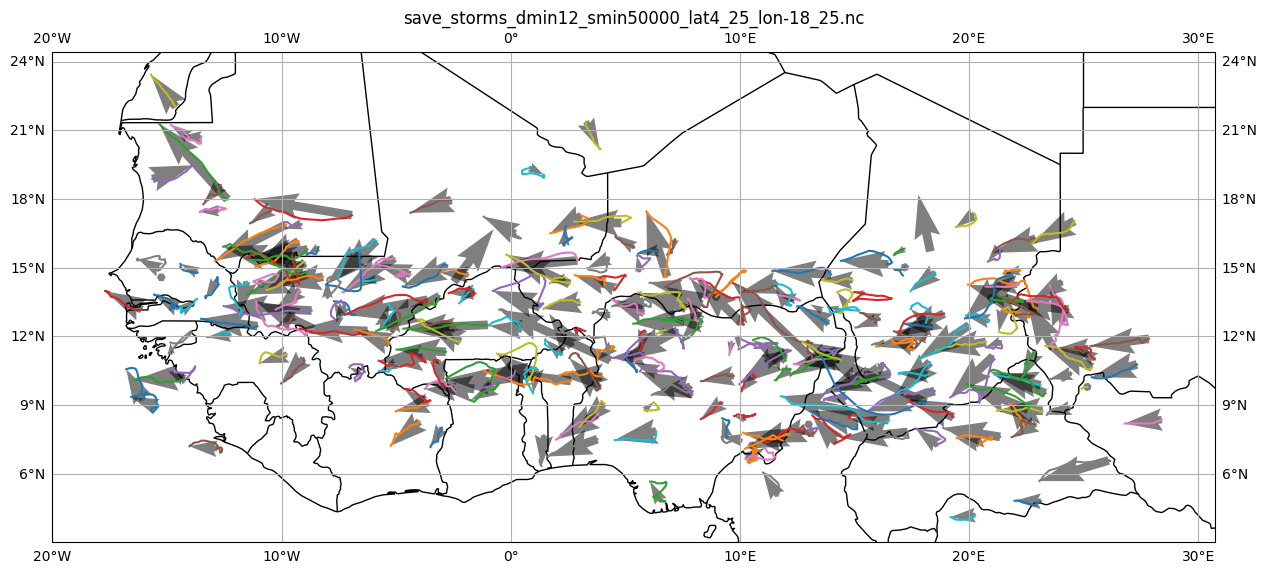

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

for iDCS in ft.DCS_number.values:
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = 1.5)
    
    lons = (lons + 180) % 360 - 180
    lons_3d = (lons_3d + 180) % 360 - 180

    lon_smax = lons[i_smax]
    lat_smax =  lats[i_smax]
    lon_propa = lon_smax - lons[0]
    lat_propa = lat_smax - lats[0]

    plt.plot(lons[:i_smax+1], lats[:i_smax+1])
    plt.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, alpha = 0.5, angles='xy', scale_units='xy')

plt.title(save_storms_path.split("/")[-1])

In [23]:
all_lons = ft.LC_lon.values
all_lons = (all_lons+180)%360 - 180
min_lons =np.nanmin(all_lons, axis = 1)
MY_TARGET = np.where((min_lons < -12) & (np.nanmin(ft.LC_lat.values, axis = 1)<6))
ft.DCS_number[MY_TARGET]

<xarray.DataArray 'DCS_number' (DCS_number: 2)>
array([240775, 264913])
Coordinates:
  * DCS_number  (DCS_number) int64 240775 264913

## High Propagation Systems (Non Stationary)

In [9]:
import os 

duration_min = 12
surfmaxkm2_min = 50000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
filename_save = f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
save_storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)

# os.remove(save_storms_path)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    #### HIGH PROPAGATION ####
    storms = storms.where(storms.INT_velocityAvg > 3, drop=True)  # 1min
    storms = storms.where(storms.INT_distance > 500, drop=True)  # 1min

    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

## FileTracking is ft
ft = storms[[ 
    "INT_velocityAvg", "INT_distance", "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K", 
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity"
             ]]


to_drop = []
for iDCS in ft.DCS_number.values : 
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = st.get_frame_data(ft, iDCS)
    # extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d)
    times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
    t = len(times_3d_conv)
    if t<3 or i_smax < 0:
        to_drop.append(iDCS)
ft = ft.drop_sel(DCS_number = to_drop)

Text(0.5, 1.0, 'shearhigh_prop_dmin12_smin50000_lat4_25_lon-18_25.nc')

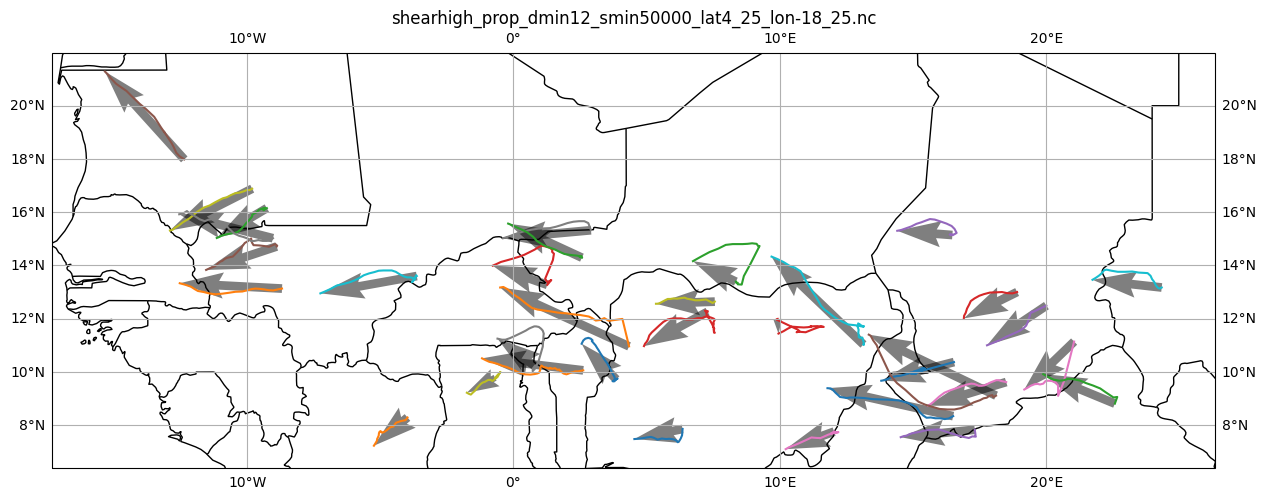

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

## Valid times for 3d var are %6==0 
t=0
ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0])


for iDCS in ft_3d.DCS_number.values:
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = 1.5)
    
    lons = (lons + 180) % 360 - 180
    lons_3d = (lons_3d + 180) % 360 - 180

    lon_smax = lons[i_smax]
    lat_smax =  lats[i_smax]
    lon_propa = lon_smax - lons[0]
    lat_propa = lat_smax - lats[0]

    plt.plot(lons[:i_smax+1], lats[:i_smax+1])
    plt.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, alpha = 0.5, angles='xy', scale_units='xy')

plt.title(save_storms_path.split("/")[-1])

### Low propa

In [11]:
import os 

duration_min = 12
surfmaxkm2_min = 50000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
filename_save = f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
save_storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    #### HIGH PROPAGATION ####
    # storms = storms.where(storms.INT_velocityAvg > 3, drop=True)  # 1min
    # storms = storms.where(storms.INT_distance > 500, drop=True)  # 1min

    ### LOW PROPAGATION ####
    storms = storms.where(storms.INT_velocityAvg <= 3, drop=True)  # 1min
    storms = storms.where(storms.INT_distance <= 500, drop=True)  # 1min

    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

## FileTracking is ft
ft = storms[[ 
    "INT_velocityAvg", "INT_distance", "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K",
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity" 
             ]]

# # to_drop = []
# for iDCS in ft.DCS_number.values : 
#     start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = st.get_frame_data(ft, iDCS)
#     # extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d)
#     times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
#     # t = len(times_3d_conv)
#     # if t<2 or i_smax < 0:
#     #     to_drop.append(iDCS)
# # ft = ft.drop_sel(DCS_number = to_drop)


Text(0.5, 1.0, 'shearlow_prop_dmin12_smin50000_lat4_25_lon-18_25.nc')

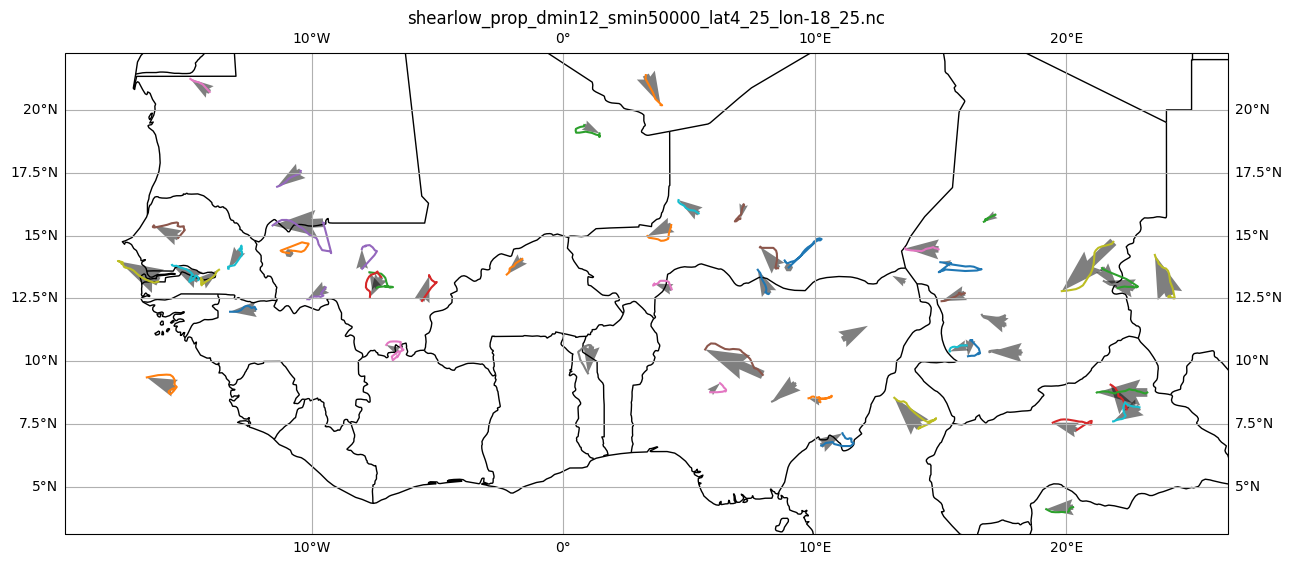

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

## Valid times for 3d var are %6==0 
t=0
ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0])


for iDCS in ft_3d.DCS_number.values:
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = 1.5)
    
    lons = (lons + 180) % 360 - 180
    lons_3d = (lons_3d + 180) % 360 - 180

    lon_smax = lons[i_smax]
    lat_smax =  lats[i_smax]
    lon_propa = lon_smax - lons[0]
    lat_propa = lat_smax - lats[0]

    plt.plot(lons[:i_smax+1], lats[:i_smax+1])
    plt.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, alpha = 0.5, angles='xy', scale_units='xy')

plt.title(save_storms_path.split("/")[-1])

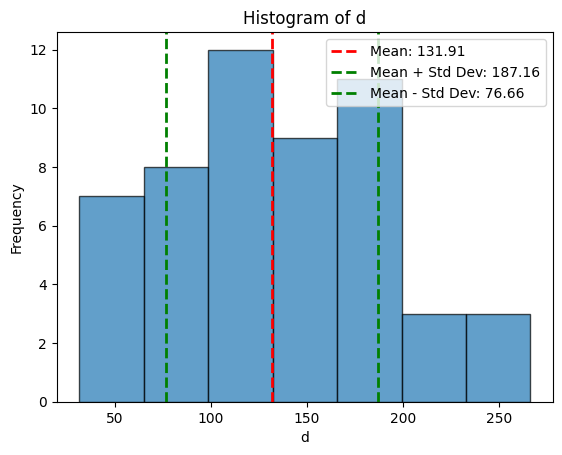

In [14]:
simple_hist(ft_3d.INT_distance, "d")

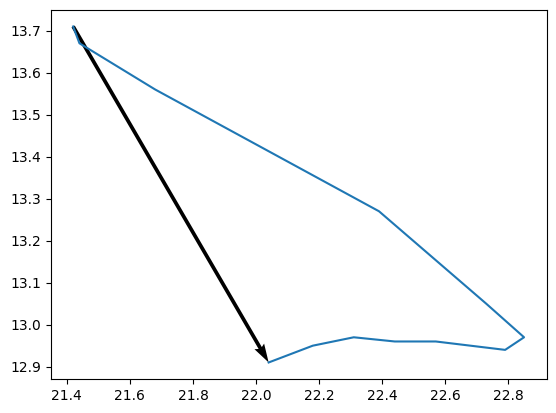

In [15]:
fig, ax = plt.subplots(1,1)
lon_smax = lons[i_smax]
lat_smax =  lats[i_smax]
lon_propa = lon_smax - lons[0]
lat_propa = lat_smax - lats[0]

plt.plot(lons[:i_smax+1], lats[:i_smax+1])

plt.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, angles='xy', scale_units='xy')